# For an analysis competition...
What to predict?
- age ... too few nans (prediction may be meaningless...)
- cancellation of premium membership

# Libraries

In [59]:
# basics
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import json
import time
import datetime
import os
import sys
import pickle
from tqdm import tqdm_notebook as tqdm

# keras
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, LambdaCallback
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.layers import Input, Layer, Dense, Concatenate, Reshape, Dropout, merge, Add, BatchNormalization, GaussianNoise
from keras.layers.embeddings import Embedding
from keras import backend as K
from keras.layers import Layer
from keras.callbacks import *
import tensorflow as tf
import math

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib_venn import venn2
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
import plotly.figure_factory as ff
import plotly.express as px
import missingno as msno

sns.set_context("talk")
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
style.use('fivethirtyeight')

# custom EDA functions
mypath = os.getcwd()
sys.path.append(mypath + '/code/') 
from utils import reduce_mem_usage, plot_target
from categorical_encoder import label_encoding
from feature_converter import categorize_features
from adversarial_validaton import AdversarialValidation
from catplot import CategoricalVisualizer
from denseplot import DenseVisualizer
from nn_utils import Mish, LayerNormalization, CyclicLR
from permutation_importance import PermulationImportance

# custom modeling functions
sys.path.append(mypath + '/models/') 
from base_models import BaseModel
from lgb_models import LgbModel
from catb_models import CatbModel

# stats
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import scipy as sp
from functools import partial
from collections import Counter

pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

print("libraries imported")

libraries imported


# Load data

In [60]:
!ls

EDA.ipynb            EDA_titanic.ipynb    models
EDA_houseprice.ipynb code                 nn_laputa.ipynb
EDA_laputa.ipynb     inputs


In [61]:
# check path
datapath = "inputs/"
datapath = "/Volumes/sec/anemos-poc-large-sec/users/kakawagu/data/laputa_comp"
files = os.listdir(datapath)
print(files)

['laputa_age.csv', 'laputa.csv', 'laputa_noage.csv']


In [62]:
# import data
time0 = time.time()

train = pd.read_csv(datapath + '/laputa_age.csv', index_col=0)
test = pd.read_csv(datapath + '/laputa_noage.csv', index_col=0)

time1 = time.time()
print(time1 - time0, " seconds to load data")

36.01105284690857  seconds to load data


In [63]:
# check train
print(train.shape)
train.head()

(10000, 815)


,y_id_hex,1_y_id_master_gender,1_y_id_master_birthday,1_y_id_master_registration_date,1_y_id_master_first_update,1_y_id_master_last_update,1_y_id_master_age,1_y_id_master_registration_month,1_y_id_master_registration_week,2_user_profile_master_commerce_registration_month,...,99_yup_user_daily_score_2_interest_know_well_world_history,99_yup_user_daily_score_2_interest_know_well_art,99_yup_user_daily_score_2_interest_know_well_iphone,99_yup_user_daily_score_2_interest_know_well_android,99_yup_user_daily_score_2_interest_know_well_pc,99_yup_user_daily_score_2_interest_know_well_home_appliance,99_yup_user_daily_score_2_interest_starting_own_business,99_yup_user_daily_score_2_interest_know_well_stock_economy,99_yup_user_daily_score_2_interest_know_well_internet_setup,99_yup_user_daily_score_2_interest_know_well_construction
0,0012356A351358D871,1,NaN,20190428,20190501.0,20191201,49,8,31,8,...,NaN,0.067452,NaN,NaN,NaN,NaN,0.05795,NaN,NaN,NaN
1,00148ED6D273F9B2DD,1,NaN,20160925,20160929.0,20191127,45,39,166,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0003BCA15E2EFB1955,1,NaN,20160508,20160513.0,20191130,23,43,186,43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000A7D82545E783A8E,1,NaN,20160612,20160615.0,20191201,42,42,181,42,...,NaN,0.035689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000A84CEFE8881F2AA,1,NaN,20191020,20191022.0,20191201,58,2,6,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
# check test
print(test.shape)
test.head()

(10000, 815)


,y_id_hex,1_y_id_master_gender,1_y_id_master_birthday,1_y_id_master_registration_date,1_y_id_master_first_update,1_y_id_master_last_update,1_y_id_master_age,1_y_id_master_registration_month,1_y_id_master_registration_week,2_user_profile_master_commerce_registration_month,...,99_yup_user_daily_score_2_interest_know_well_world_history,99_yup_user_daily_score_2_interest_know_well_art,99_yup_user_daily_score_2_interest_know_well_iphone,99_yup_user_daily_score_2_interest_know_well_android,99_yup_user_daily_score_2_interest_know_well_pc,99_yup_user_daily_score_2_interest_know_well_home_appliance,99_yup_user_daily_score_2_interest_starting_own_business,99_yup_user_daily_score_2_interest_know_well_stock_economy,99_yup_user_daily_score_2_interest_know_well_internet_setup,99_yup_user_daily_score_2_interest_know_well_construction
0,0013CB9311A8ADDE2C,0,NaN,20170528,20170530.0,20191201,NaN,31,131,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00039645C6FA1C0ABC,0,NaN,20190224,20190301.0,20191201,NaN,10,40,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00151F8DE7DFD5D93C,0,NaN,20190623,20190627.0,20191201,NaN,6,23,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000C53CB2E2051E6A2,0,NaN,20190616,20190620.0,20191201,NaN,6,24,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0012E6705A765C2DA2,0,NaN,20190922,20190923.0,20191201,NaN,3,10,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Target

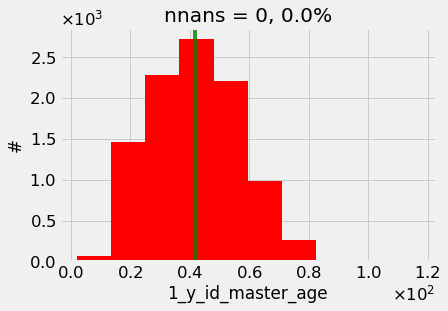

In [65]:
# hist
target = "1_y_id_master_age"
plot_target(train, target, objective="regression")

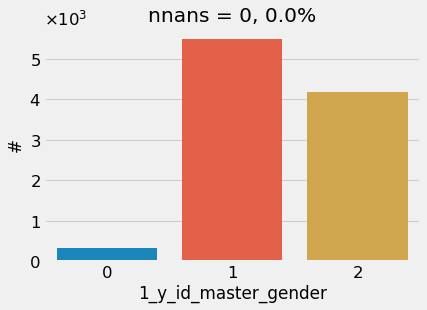

In [66]:
# hist
target = "1_y_id_master_gender"
plot_target(train, target, objective="classification")

In [67]:
# binarize gender
train["1_y_id_master_gender"] -= 1
train.loc[train["1_y_id_master_gender"] < 0, "1_y_id_master_gender"] = 0

# multi-task
target = ["1_y_id_master_age", "1_y_id_master_gender"]

# Dense features

In [68]:
dense_features = ['1_y_id_master_registration_date', '1_y_id_master_first_update', '1_y_id_master_last_update', '1_y_id_master_registration_month', '1_y_id_master_registration_week', '2_user_profile_master_commerce_registration_month', '2_user_profile_master_commerce_age', '2_user_profile_master_commerce_shopping_order_count', '2_user_profile_master_commerce_auction_won_count', '2_user_profile_master_commerce_auction_bid_aid_count', '2_user_profile_master_commerce_auction_submit_count', '2_user_profile_master_commerce_auction_sold_count', '2_user_profile_master_commerce_earned_point_count', '2_user_profile_master_commerce_monthly_fixed_point', '2_user_profile_master_commerce_used_point_count', '2_user_profile_master_commerce_used_point', '2_user_profile_master_commerce_invalid_ypoint', '3_points_monthly_summary_interim_point_y', '3_points_monthly_summary_fixed_point_y', '3_points_monthly_summary_fixed_point_t', '4_point_user_balance_master_interim_point_y', '4_point_user_balance_master_fixed_point_y', '4_point_user_balance_master_fixed_point_t', '8_app_user_monthly_stats_toppage_activate_day', '8_app_user_monthly_stats_weather_activate_day', '8_app_user_monthly_stats_transit_activate_day', '8_app_user_monthly_stats_shopping_activate_day', '8_app_user_monthly_stats_gyao_activate_day', '8_app_user_monthly_stats_auctions_activate_day', '8_app_user_monthly_stats_mail_activate_day', '8_app_user_monthly_stats_yjtrend_activate_day', '8_app_user_monthly_stats_apppkgcal_activate_day', '8_app_user_monthly_stats_ymail_activate_day', '8_app_user_monthly_stats_ysmarttool_activate_day', '8_app_user_monthly_stats_ynaviapp_activate_day', '8_app_user_monthly_stats_maps_activate_day', '8_app_user_monthly_stats_sportsnavi_activate_day', '8_app_user_monthly_stats_ymobile_activate_day', '8_app_user_monthly_stats_ysmartsecurity_activate_day', '8_app_user_monthly_stats_yjcal_activate_day', '8_app_user_monthly_stats_yfiler_activate_day', '8_app_user_monthly_stats_finance_activate_day', '8_app_user_monthly_stats_ebookjapan_activate_day', '8_app_user_monthly_stats_toppage_activate_count', '8_app_user_monthly_stats_weather_activate_count', '8_app_user_monthly_stats_transit_activate_count', '8_app_user_monthly_stats_shopping_activate_count', '8_app_user_monthly_stats_gyao_activate_count', '8_app_user_monthly_stats_auctions_activate_count', '8_app_user_monthly_stats_mail_activate_count', '8_app_user_monthly_stats_yjtrend_activate_count', '8_app_user_monthly_stats_apppkgcal_activate_count', '8_app_user_monthly_stats_ymail_activate_count', '8_app_user_monthly_stats_emg_activate_count', '8_app_user_monthly_stats_ysmarttool_activate_count', '8_app_user_monthly_stats_ynaviapp_activate_count', '8_app_user_monthly_stats_maps_activate_count', '8_app_user_monthly_stats_sportsnavi_activate_count', '8_app_user_monthly_stats_ymobile_activate_count', '8_app_user_monthly_stats_ysmartsecurity_activate_count', '8_app_user_monthly_stats_yjcal_activate_count', '8_app_user_monthly_stats_yfiler_activate_count', '8_app_user_monthly_stats_finance_activate_count', '8_app_user_monthly_stats_ybackup_activate_count', '8_app_user_monthly_stats_chiebukuro_activate_count', '8_app_user_monthly_stats_ebookjapan_activate_count', '8_app_user_monthly_stats_pmall_activate_count', '8_app_user_monthly_stats_ychiebukuro_activate_count', '8_app_user_monthly_stats_toppage_duration', '8_app_user_monthly_stats_weather_duration', '8_app_user_monthly_stats_transit_duration', '8_app_user_monthly_stats_shopping_duration', '8_app_user_monthly_stats_gyao_duration', '8_app_user_monthly_stats_auctions_duration', '8_app_user_monthly_stats_mail_duration', '8_app_user_monthly_stats_yjtrend_duration', '8_app_user_monthly_stats_apppkgcal_duration', '8_app_user_monthly_stats_ymail_duration', '8_app_user_monthly_stats_emg_duration', '8_app_user_monthly_stats_ysmarttool_duration', '8_app_user_monthly_stats_ynaviapp_duration', '8_app_user_monthly_stats_maps_duration', '8_app_user_monthly_stats_sportsnavi_duration', '8_app_user_monthly_stats_ymobile_duration', '8_app_user_monthly_stats_ysmartsecurity_duration', '8_app_user_monthly_stats_yjcal_duration', '8_app_user_monthly_stats_yfiler_duration', '8_app_user_monthly_stats_finance_duration', '8_app_user_monthly_stats_ybackup_duration', '8_app_user_monthly_stats_chiebukuro_duration', '8_app_user_monthly_stats_ebookjapan_duration', '8_app_user_monthly_stats_pmall_duration', '8_app_user_monthly_stats_ymsetupman_duration', '8_app_user_monthly_stats_ychiebukuro_duration', '8_app_user_monthly_stats_realestate_duration', '8_app_user_monthly_stats_weather_widget_activate_day']

# Categorical features

In [69]:
cat_features = ['y_id_hex', '1_y_id_master_gender', '2_user_profile_master_commerce_gender', '2_user_profile_master_commerce_generation1', '2_user_profile_master_commerce_generation3', '2_user_profile_master_commerce_generation5', '2_user_profile_master_commerce_premium_user_flag', '2_user_profile_master_commerce_wallet_registered_flag', '2_user_profile_master_commerce_valid_card_count', '2_user_profile_master_commerce_auction_store_flag', '8_app_user_monthly_stats_toppage_flag', '8_app_user_monthly_stats_weather_flag', '8_app_user_monthly_stats_transit_flag', '8_app_user_monthly_stats_shopping_flag', '8_app_user_monthly_stats_gyao_flag', '8_app_user_monthly_stats_auctions_flag', '8_app_user_monthly_stats_mail_flag', '8_app_user_monthly_stats_yjtrend_flag', '8_app_user_monthly_stats_apppkgcal_flag', '8_app_user_monthly_stats_ymail_flag', '8_app_user_monthly_stats_emg_flag', '8_app_user_monthly_stats_ysmarttool_flag', '8_app_user_monthly_stats_ybrowser_flag', '8_app_user_monthly_stats_ynaviapp_flag', '8_app_user_monthly_stats_npb_textlive_flag', '8_app_user_monthly_stats_maps_flag', '8_app_user_monthly_stats_sportsnavi_flag', '8_app_user_monthly_stats_ymobile_flag', '8_app_user_monthly_stats_ysmartsecurity_flag', '8_app_user_monthly_stats_yjcal_flag', '8_app_user_monthly_stats_yfiler_flag', '8_app_user_monthly_stats_apps_map_flag', '8_app_user_monthly_stats_apps_navi_flag', '8_app_user_monthly_stats_finance_flag', '8_app_user_monthly_stats_ybackup_flag', '8_app_user_monthly_stats_chiebukuro_flag', '8_app_user_monthly_stats_yqrcode_flag', '8_app_user_monthly_stats_launcher_buzzhome_flag', '8_app_user_monthly_stats_ebookjapan_flag', '8_app_user_monthly_stats_pmall_flag', '8_app_user_monthly_stats_ymsetupman_flag', '8_app_user_monthly_stats_realtime_buzzalert_flag', '8_app_user_monthly_stats_ychiebukuro_flag', '8_app_user_monthly_stats_ybuzzdetection_flag', '8_app_user_monthly_stats_com_cf_selene_flag', '8_app_user_monthly_stats_realestate_flag', '8_app_user_monthly_stats_minkara_flag', '8_app_user_monthly_stats_com_cf_calendar_flag', '8_app_user_monthly_stats_com_cf_coletto_flag', '8_app_user_monthly_stats_v_assist_flag', '8_app_user_monthly_stats_yfinkeyguardwidget_flag', '8_app_user_monthly_stats_partner_flag', '8_app_user_monthly_stats_com_cfinc_calendar_flag', '8_app_user_monthly_stats_jp_trilltrill_trill_flag', '8_app_user_monthly_stats_yphoto_flag', '8_app_user_monthly_stats_appcover_launcher2_flag', '8_app_user_monthly_stats_com_cfinc_coletto_flag', '8_app_user_monthly_stats_fortune_flag', '8_app_user_monthly_stats_netallica_flag', '8_app_user_monthly_stats_hitouch_flag', '8_app_user_monthly_stats_bookstore_flag', '8_app_user_monthly_stats_voicesearch_flag', '8_app_user_monthly_stats_ybrowser2_flag', '8_app_user_monthly_stats_prem_sports_flag', '8_app_user_monthly_stats_scpro_flag', '8_app_user_monthly_stats_news_tablet_flag', '8_app_user_monthly_stats_wallet_transfer_flag', '8_app_user_monthly_stats_travel_flag', '8_app_user_monthly_stats_timetv_flag', '8_app_user_monthly_stats_passmarket_flag', '8_app_user_monthly_stats_latlonglab_flag', '8_app_user_monthly_stats_yshopping_raku_flag', '8_app_user_monthly_stats_mythingsapp_flag', '8_app_user_monthly_stats_maplocationshare_flag', '8_app_user_monthly_stats_emg_activate_day', '8_app_user_monthly_stats_ybrowser_activate_day', '8_app_user_monthly_stats_npb_textlive_activate_day', '8_app_user_monthly_stats_apps_map_activate_day', '8_app_user_monthly_stats_apps_navi_activate_day', '8_app_user_monthly_stats_ybackup_activate_day', '8_app_user_monthly_stats_chiebukuro_activate_day', '8_app_user_monthly_stats_yqrcode_activate_day', '8_app_user_monthly_stats_launcher_buzzhome_activate_day', '8_app_user_monthly_stats_pmall_activate_day', '8_app_user_monthly_stats_ymsetupman_activate_day', '8_app_user_monthly_stats_realtime_buzzalert_activate_day', '8_app_user_monthly_stats_ychiebukuro_activate_day', '8_app_user_monthly_stats_ybuzzdetection_activate_day', '8_app_user_monthly_stats_com_cf_selene_activate_day', '8_app_user_monthly_stats_realestate_activate_day', '8_app_user_monthly_stats_minkara_activate_day', '8_app_user_monthly_stats_com_cf_calendar_activate_day', '8_app_user_monthly_stats_com_cf_coletto_activate_day', '8_app_user_monthly_stats_v_assist_activate_day', '8_app_user_monthly_stats_yfinkeyguardwidget_activate_day', '8_app_user_monthly_stats_partner_activate_day', '8_app_user_monthly_stats_com_cfinc_calendar_activate_day', '8_app_user_monthly_stats_jp_trilltrill_trill_activate_day', '8_app_user_monthly_stats_yphoto_activate_day', '8_app_user_monthly_stats_appcover_launcher2_activate_day', '8_app_user_monthly_stats_com_cfinc_coletto_activate_day', '8_app_user_monthly_stats_fortune_activate_day', '8_app_user_monthly_stats_netallica_activate_day', '8_app_user_monthly_stats_hitouch_activate_day', '8_app_user_monthly_stats_bookstore_activate_day', '8_app_user_monthly_stats_voicesearch_activate_day', '8_app_user_monthly_stats_ybrowser2_activate_day', '8_app_user_monthly_stats_prem_sports_activate_day', '8_app_user_monthly_stats_scpro_activate_day', '8_app_user_monthly_stats_news_tablet_activate_day', '8_app_user_monthly_stats_wallet_transfer_activate_day', '8_app_user_monthly_stats_travel_activate_day', '8_app_user_monthly_stats_timetv_activate_day', '8_app_user_monthly_stats_passmarket_activate_day', '8_app_user_monthly_stats_latlonglab_activate_day', '8_app_user_monthly_stats_yshopping_raku_activate_day', '8_app_user_monthly_stats_mythingsapp_activate_day', '8_app_user_monthly_stats_maplocationshare_activate_day', '8_app_user_monthly_stats_ybrowser_activate_count', '8_app_user_monthly_stats_npb_textlive_activate_count', '8_app_user_monthly_stats_apps_map_activate_count', '8_app_user_monthly_stats_apps_navi_activate_count', '8_app_user_monthly_stats_yqrcode_activate_count', '8_app_user_monthly_stats_launcher_buzzhome_activate_count', '8_app_user_monthly_stats_ymsetupman_activate_count', '8_app_user_monthly_stats_realtime_buzzalert_activate_count', '8_app_user_monthly_stats_ybuzzdetection_activate_count', '8_app_user_monthly_stats_com_cf_selene_activate_count', '8_app_user_monthly_stats_realestate_activate_count', '8_app_user_monthly_stats_minkara_activate_count', '8_app_user_monthly_stats_com_cf_calendar_activate_count', '8_app_user_monthly_stats_com_cf_coletto_activate_count', '8_app_user_monthly_stats_v_assist_activate_count', '8_app_user_monthly_stats_yfinkeyguardwidget_activate_count', '8_app_user_monthly_stats_partner_activate_count', '8_app_user_monthly_stats_com_cfinc_calendar_activate_count', '8_app_user_monthly_stats_jp_trilltrill_trill_activate_count', '8_app_user_monthly_stats_yphoto_activate_count', '8_app_user_monthly_stats_appcover_launcher2_activate_count', '8_app_user_monthly_stats_com_cfinc_coletto_activate_count', '8_app_user_monthly_stats_fortune_activate_count', '8_app_user_monthly_stats_netallica_activate_count', '8_app_user_monthly_stats_hitouch_activate_count', '8_app_user_monthly_stats_bookstore_activate_count', '8_app_user_monthly_stats_voicesearch_activate_count', '8_app_user_monthly_stats_ybrowser2_activate_count', '8_app_user_monthly_stats_prem_sports_activate_count', '8_app_user_monthly_stats_scpro_activate_count', '8_app_user_monthly_stats_news_tablet_activate_count', '8_app_user_monthly_stats_wallet_transfer_activate_count', '8_app_user_monthly_stats_travel_activate_count', '8_app_user_monthly_stats_timetv_activate_count', '8_app_user_monthly_stats_passmarket_activate_count', '8_app_user_monthly_stats_latlonglab_activate_count', '8_app_user_monthly_stats_yshopping_raku_activate_count', '8_app_user_monthly_stats_mythingsapp_activate_count', '8_app_user_monthly_stats_maplocationshare_activate_count', '8_app_user_monthly_stats_ybrowser_duration', '8_app_user_monthly_stats_npb_textlive_duration', '8_app_user_monthly_stats_apps_map_duration', '8_app_user_monthly_stats_apps_navi_duration', '8_app_user_monthly_stats_yqrcode_duration', '8_app_user_monthly_stats_launcher_buzzhome_duration', '8_app_user_monthly_stats_realtime_buzzalert_duration', '8_app_user_monthly_stats_ybuzzdetection_duration', '8_app_user_monthly_stats_com_cf_selene_duration', '8_app_user_monthly_stats_minkara_duration', '8_app_user_monthly_stats_com_cf_calendar_duration', '8_app_user_monthly_stats_com_cf_coletto_duration', '8_app_user_monthly_stats_v_assist_duration', '8_app_user_monthly_stats_yfinkeyguardwidget_duration', '8_app_user_monthly_stats_partner_duration', '8_app_user_monthly_stats_com_cfinc_calendar_duration', '8_app_user_monthly_stats_jp_trilltrill_trill_duration', '8_app_user_monthly_stats_yphoto_duration', '8_app_user_monthly_stats_appcover_launcher2_duration', '8_app_user_monthly_stats_com_cfinc_coletto_duration', '8_app_user_monthly_stats_fortune_duration', '8_app_user_monthly_stats_netallica_duration', '8_app_user_monthly_stats_hitouch_duration', '8_app_user_monthly_stats_bookstore_duration', '8_app_user_monthly_stats_voicesearch_duration', '8_app_user_monthly_stats_ybrowser2_duration', '8_app_user_monthly_stats_prem_sports_duration', '8_app_user_monthly_stats_scpro_duration', '8_app_user_monthly_stats_news_tablet_duration', '8_app_user_monthly_stats_wallet_transfer_duration', '8_app_user_monthly_stats_travel_duration', '8_app_user_monthly_stats_timetv_duration', '8_app_user_monthly_stats_passmarket_duration', '8_app_user_monthly_stats_latlonglab_duration', '8_app_user_monthly_stats_yshopping_raku_duration', '8_app_user_monthly_stats_mythingsapp_duration', '8_app_user_monthly_stats_maplocationshare_duration', '8_app_user_monthly_stats_toppage_widget_activate_day', '8_app_user_monthly_stats_transit_widget_activate_day', '8_app_user_monthly_stats_shopping_widget_activate_day', '8_app_user_monthly_stats_gyao_widget_activate_day', '8_app_user_monthly_stats_auctions_widget_activate_day', '8_app_user_monthly_stats_mail_widget_activate_day', '8_app_user_monthly_stats_yjtrend_widget_activate_day', '8_app_user_monthly_stats_apppkgcal_widget_activate_day', '8_app_user_monthly_stats_ymail_widget_activate_day', '8_app_user_monthly_stats_emg_widget_activate_day', '8_app_user_monthly_stats_ysmarttool_widget_activate_day', '8_app_user_monthly_stats_ybrowser_widget_activate_day', '8_app_user_monthly_stats_ynaviapp_widget_activate_day', '8_app_user_monthly_stats_npb_textlive_widget_activate_day', '8_app_user_monthly_stats_maps_widget_activate_day', '8_app_user_monthly_stats_sportsnavi_widget_activate_day', '8_app_user_monthly_stats_ymobile_widget_activate_day', '8_app_user_monthly_stats_ysmartsecurity_widget_activate_day', '8_app_user_monthly_stats_yjcal_widget_activate_day', '8_app_user_monthly_stats_yfiler_widget_activate_day', '8_app_user_monthly_stats_apps_map_widget_activate_day', '8_app_user_monthly_stats_apps_navi_widget_activate_day', '8_app_user_monthly_stats_finance_widget_activate_day', '8_app_user_monthly_stats_ybackup_widget_activate_day', '8_app_user_monthly_stats_chiebukuro_widget_activate_day', '8_app_user_monthly_stats_yqrcode_widget_activate_day', '8_app_user_monthly_stats_launcher_buzzhome_widget_activate_day', '8_app_user_monthly_stats_ebookjapan_widget_activate_day', '8_app_user_monthly_stats_pmall_widget_activate_day', '8_app_user_monthly_stats_ymsetupman_widget_activate_day', '8_app_user_monthly_stats_realtime_buzzalert_widget_activate_day', '8_app_user_monthly_stats_ychiebukuro_widget_activate_day', '8_app_user_monthly_stats_ybuzzdetection_widget_activate_day', '8_app_user_monthly_stats_com_cf_selene_widget_activate_day', '8_app_user_monthly_stats_realestate_widget_activate_day', '8_app_user_monthly_stats_minkara_widget_activate_day', '8_app_user_monthly_stats_com_cf_calendar_widget_activate_day', '8_app_user_monthly_stats_com_cf_coletto_widget_activate_day', '8_app_user_monthly_stats_v_assist_widget_activate_day', '8_app_user_monthly_stats_yfinkeyguardwidget_widget_activate_day', '8_app_user_monthly_stats_partner_widget_activate_day', '8_app_user_monthly_stats_com_cfinc_calendar_widget_activate_day', '8_app_user_monthly_stats_jp_trilltrill_trill_widget_activate_day', '8_app_user_monthly_stats_yphoto_widget_activate_day', '8_app_user_monthly_stats_appcover_launcher2_widget_activate_day', '8_app_user_monthly_stats_com_cfinc_coletto_widget_activate_day', '8_app_user_monthly_stats_fortune_widget_activate_day', '8_app_user_monthly_stats_netallica_widget_activate_day', '8_app_user_monthly_stats_hitouch_widget_activate_day', '8_app_user_monthly_stats_bookstore_widget_activate_day', '8_app_user_monthly_stats_voicesearch_widget_activate_day', '8_app_user_monthly_stats_ybrowser2_widget_activate_day', '8_app_user_monthly_stats_prem_sports_widget_activate_day', '8_app_user_monthly_stats_scpro_widget_activate_day', '8_app_user_monthly_stats_news_tablet_widget_activate_day', '8_app_user_monthly_stats_wallet_transfer_widget_activate_day', '8_app_user_monthly_stats_travel_widget_activate_day', '8_app_user_monthly_stats_timetv_widget_activate_day', '8_app_user_monthly_stats_passmarket_widget_activate_day', '8_app_user_monthly_stats_latlonglab_widget_activate_day', '8_app_user_monthly_stats_yshopping_raku_widget_activate_day', '8_app_user_monthly_stats_mythingsapp_widget_activate_day', '8_app_user_monthly_stats_maplocationshare_widget_activate_day']

# Drop leaky columns

In [70]:
# drop leak features
dropcols = ['2_user_profile_master_commerce_age', '2_user_profile_master_commerce_generation1', '2_user_profile_master_commerce_generation3', '2_user_profile_master_commerce_generation5', '2_user_profile_master_commerce_generation7']
dropcols = dropcols + ["1_y_id_master_gender", "2_user_profile_master_commerce_gender"]
group = "y_id_hex"
dropcols = dropcols + target + [group]
features = dense_features + cat_features
features = [f for f in features if f not in dropcols]
cat_features = [f for f in cat_features if f not in dropcols]
print(len(features))

346


# NN model

In [71]:
params = {
            'input_dropout': 0.0,
            'hidden_layers': 3,
            'hidden_units': 128,
            'embedding_out_dim': 8,
            'hidden_activation': 'relu',
            'hidden_dropout': 0.05,
            'batch_norm': 'before_act',
            'optimizer': {'type': 'adam', 'lr': 0.001},
            'batch_size': 128,
            'epochs': 80
        }

# MLP model
def MLP(train, train_panda, features, categoricals):
    inputs = []
    embeddings = []
    embedding_out_dim = params['embedding_out_dim']
    n_neuron = params['hidden_units']
    for i in categoricals:
        input_ = Input(shape=(1,))
        embedding = Embedding(int(np.absolute(train_panda[i]).max() + 1), embedding_out_dim, input_length=1)(input_)
        embedding = Reshape(target_shape=(embedding_out_dim,))(embedding)
        inputs.append(input_)
        embeddings.append(embedding)
    input_numeric = Input(shape=(len(features) - len(categoricals),))
    embedding_numeric = Dense(n_neuron)(input_numeric)
    embedding_numeric = Mish()(embedding_numeric)
    inputs.append(input_numeric)
    embeddings.append(embedding_numeric)
    x = Concatenate()(embeddings)
    for i in np.arange(params['hidden_layers'] - 1):
        x = Dense(n_neuron // (2 * (i+1)))(x)
        x = Mish()(x)
        x = Dropout(params['hidden_dropout'])(x)
        x = LayerNormalization()(x)
    out_reg = Dense(1, activation="linear", name = "out_reg")(x)
    out_cls = Dense(1, activation='sigmoid', name = 'out_cls')(x)
    model = Model(inputs=inputs, outputs=[out_reg, out_cls])

    return model

# Preprocess for fitting

In [72]:
for f in features:
    if train[f].dtype == "bool":
        train[f] = train[f].astype(int)
        test[f] = test[f].astype(int)
train = train.replace([np.inf, -np.inf], np.nan)
test = test.replace([np.inf, -np.inf], np.nan)

In [73]:
# label encoding object features
train, test = label_encoding(train, test, cat_features)
train.head()

,y_id_hex,1_y_id_master_gender,1_y_id_master_birthday,1_y_id_master_registration_date,1_y_id_master_first_update,1_y_id_master_last_update,1_y_id_master_age,1_y_id_master_registration_month,1_y_id_master_registration_week,2_user_profile_master_commerce_registration_month,...,99_yup_user_daily_score_2_interest_know_well_world_history,99_yup_user_daily_score_2_interest_know_well_art,99_yup_user_daily_score_2_interest_know_well_iphone,99_yup_user_daily_score_2_interest_know_well_android,99_yup_user_daily_score_2_interest_know_well_pc,99_yup_user_daily_score_2_interest_know_well_home_appliance,99_yup_user_daily_score_2_interest_starting_own_business,99_yup_user_daily_score_2_interest_know_well_stock_economy,99_yup_user_daily_score_2_interest_know_well_internet_setup,99_yup_user_daily_score_2_interest_know_well_construction
0,0012356A351358D871,0,NaN,20190428,20190501.0,20191201,49,8,31,8,...,NaN,0.067452,NaN,NaN,NaN,NaN,0.05795,NaN,NaN,NaN
1,00148ED6D273F9B2DD,0,NaN,20160925,20160929.0,20191127,45,39,166,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0003BCA15E2EFB1955,0,NaN,20160508,20160513.0,20191130,23,43,186,43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000A7D82545E783A8E,0,NaN,20160612,20160615.0,20191201,42,42,181,42,...,NaN,0.035689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000A84CEFE8881F2AA,0,NaN,20191020,20191022.0,20191201,58,2,6,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
print(train[target[0]].isna().sum())
print(train[target[1]].isna().sum())

0
0


In [75]:
print(test[target[0]].isna().sum())
print(test[target[1]].isna().sum())

10000
0


In [76]:
print(target[0] in features)
print(target[1] in features)

False
False


# Fitting

In [77]:
# imputation
numerical_features = [f for f in features if f not in cat_features]
train[numerical_features] = train[numerical_features].fillna(train[numerical_features].median())
test[numerical_features] = test[numerical_features].fillna(test[numerical_features].median())
train[cat_features] = train[cat_features].fillna(train[cat_features].mode())
test[cat_features] = test[cat_features].fillna(test[cat_features].mode())

# scaling
scaler = MinMaxScaler()
# scaler = StandardScaler()
df = pd.concat([train[numerical_features], test[numerical_features]], ignore_index=True)
scaler.fit(df[numerical_features])
x_test = test.copy()
x_test[numerical_features] = scaler.transform(x_test[numerical_features])
x_test = [np.absolute(x_test[i]) for i in cat_features] + [x_test[numerical_features]]
del df
gc.collect()

# group KFold
n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=1220)
unique_ids = train[group].unique()

# initialize
n_models = 2 # age, gender
oof_pred = np.zeros((train.shape[0], n_models)) 
y_pred = np.zeros((test.shape[0], n_models)) 

# callbacks for NN
er = EarlyStopping(patience=10, min_delta=1e-4, restore_best_weights=True, monitor='val_loss')
# clr = CyclicLR(base_lr=2e-4, max_lr=8e-4, step_size = 1000, gamma = 0.99)
ReduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

# group KFold
histories = []
for fold, (tr_group_idx, va_group_idx) in tqdm(enumerate(kf.split(unique_ids))):
    # split group
    tr_groups, va_groups = unique_ids[tr_group_idx], unique_ids[va_group_idx]
    train_idx = train[group].isin(tr_groups)
    val_idx = train[group].isin(va_groups)

    # train, test split
    x_train, x_val = train.loc[train_idx, features], train.loc[val_idx, features]
    y_train_age, y_val_age = train.loc[train_idx, target[0]], train.loc[val_idx, target[0]]
    y_train_gen, y_val_gen = train.loc[train_idx, target[1]], train.loc[val_idx, target[1]]

    # scale and organize matrix
    x_train[numerical_features] = scaler.transform(x_train[numerical_features])
    x_val[numerical_features] = scaler.transform(x_val[numerical_features])
    x_train = [np.absolute(x_train[i]) for i in cat_features] + [x_train[numerical_features]]
    x_val = [np.absolute(x_val[i]) for i in cat_features] + [x_val[numerical_features]]
    
    # compiling model
    model = MLP(x_train, train, features, cat_features)
    model.compile(loss=['mse', 'binary_crossentropy'], loss_weights=[1, 1],
                 optimizer=Adam(lr=1e-04, beta_1=0.9, beta_2=0.999, decay=1e-04))
    
    # fit
    history = model.fit(x_train, [y_train_age.values, y_train_gen.values], 
                                 callbacks=[er, ReduceLR], epochs=100, batch_size=512, 
                                 validation_data=[x_val, [y_val_age.values, y_val_gen.values]])
    histories.append(history)
    
    # predict
    oof_pred[val_idx, 0] = model.predict(x_val)[0].ravel()
    oof_pred[val_idx, 1] = model.predict(x_val)[1].ravel()
    y_pred[:, 0] += model.predict(x_test)[0].ravel() / n_splits
    y_pred[:, 1] += model.predict(x_test)[1].ravel() / n_splits
    
    # partial cv
    print(f"cv {fold} score for age = {np.sqrt(mean_squared_error(y_val_age, oof_pred[val_idx, 0]))}")
    print(f"cv {fold} score for gender = {roc_auc_score(y_val_gen, oof_pred[val_idx, 1])}")

Train on 6666 samples, validate on 3334 samples
Epoch 1/100


InvalidArgumentError:  indices[2,0] = -2147483648 is not in [0, 1)
	 [[node embedding_594/embedding_lookup (defined at /opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_keras_scratch_graph_153983]

Function call stack:
keras_scratch_graph


# CV

In [ ]:
# plot loss
def plot_loss(i):
    plt.plot(histories[i].history.history['loss'])
    plt.plot(histories[i].history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left ')
    plt.show()
plot_loss(n_splits)

In [ ]:
# final cv
print(f"Final cv score for age = {np.sqrt(mean_squared_error(train[target[0]].values, oof_pred[:, 0]))}")
print(f"Final cv score for gender = {roc_auc_score(train[target[1]].values, oof_pred[val_idx, 1])}")

# Permutation importance

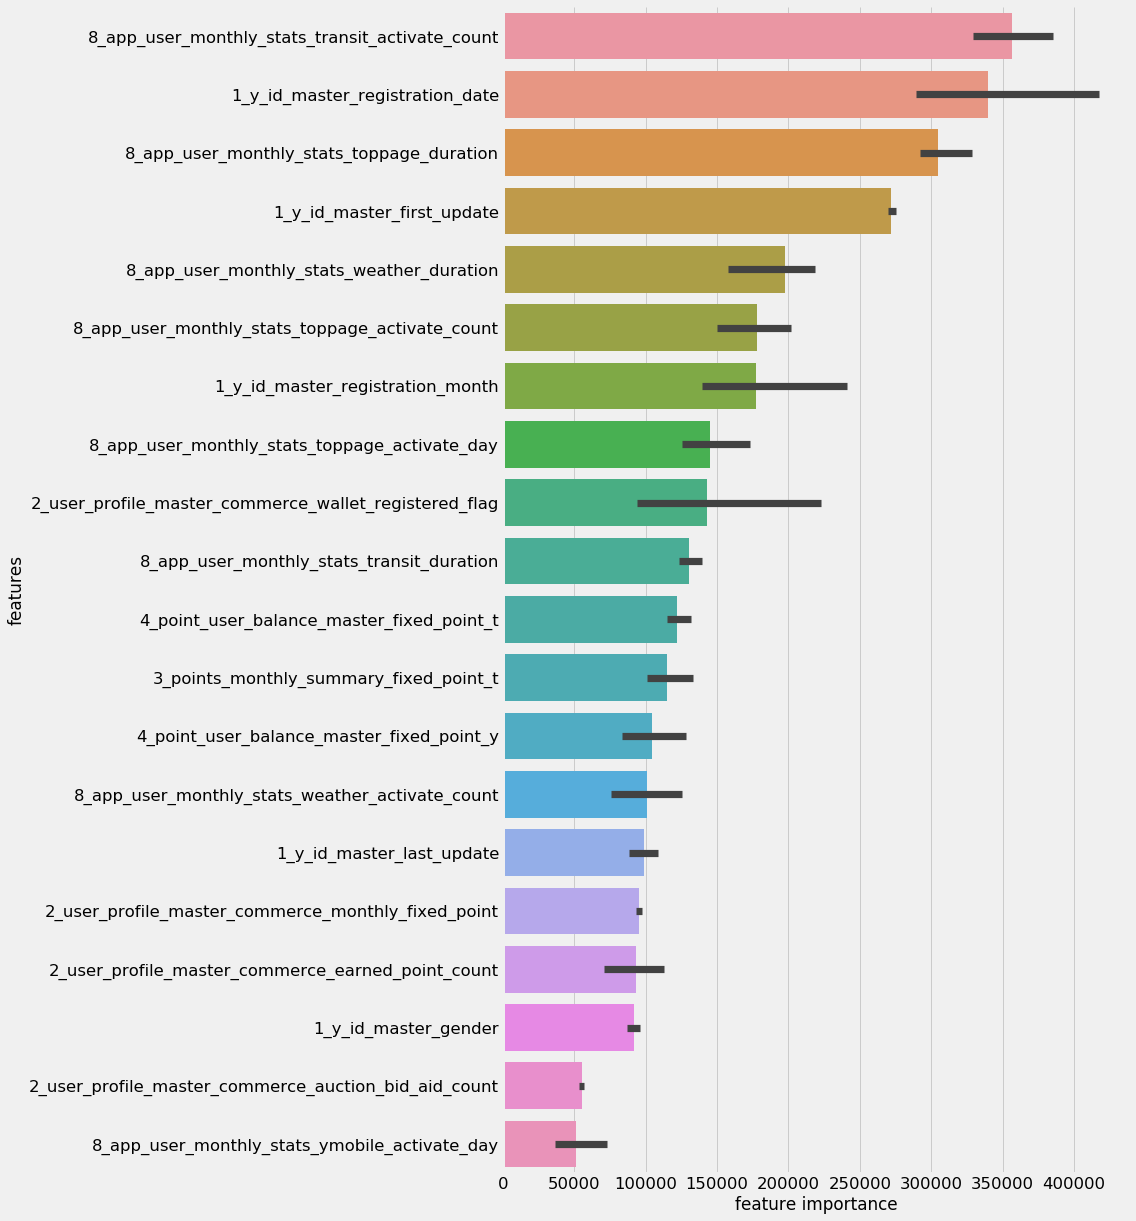

In [32]:
class PermulationImportance(object):
    """
    compute permutation importance

    """
    def __init__(self, model, X, y, features):
        self.model = model
        self.X = X
        self.y = y
        self.features = features

    def calc_metric(self):
        "smaller value is better fit"
        return mean_absolute_error(self.model.predict(self.X)[0], self.y)

    def run(self):
        baseline = self.calc_metric(self)
        imp = []
        for f in self.features:
            idx = self.features.index(f)
            save = self.X[:, idx].copy()
            self.X[:, idx] = np.random.permutation(self.X[:, idx])
            m = self.calc_metric(self)
            self.X[:, idx] = save
            imp.append(baseline - m)
        return np.array(imp)
    
# perform permutation importance
pi = PermulationImportance(model, X, y, features)
imp = pi.run()

# plot 
ranking = np.argsort(imp)
f, ax = plt.subplots(figsize=(11, 9))
sns.barplot(x=-imp[ranking], y=np.array(usecols)[ranking], orient='h')
ax.set_xlabel("permutation \nfeature importance")
plt.tight_layout()
plt.show()